# 데이터마이닝 4주차 실습

## Classification Tree
> 분기 시 변수를 두 영역으로 나누며, 목표변수(y)는 범주형(Categorical variable)
 - 분류나무는 구분 뒤 각 영역의 불순도(impurity)가 최대한 감소하도록 하는 방향으로 학습을 진행
 - 불순도, 불확실성이 감소하는 것을 정보 획득(information gain)이라고 함
 - Impurity measures : gini, entropy, $\chi^2$-stat(purity), gain ratio

In [175]:
# import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# set figure params (figure size, font size)
plt.rc('figure', figsize=(10, 8))
plt.rc('font', size=13)

### 1. Dataset

<img src="https://upload.wikimedia.org/wikipedia/commons/7/78/Petal-sepal.jpg" width="150">

+ Iris plants dataset
+ Data Set Characteristics
    - Number of Instances: 150 (50 in each of three classes)
    - Number of Attributes: 4 numeric, predictive attributes and the class
    - Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class: Iris-Setosa(0), Iris-Versicolour(1), Iris-Virginica(2)

In [176]:
# load dataset and configure dataframe
from sklearn.datasets import load_iris
iris=load_iris()
df_iris = pd.DataFrame(data=iris.data, 
                       columns= iris.feature_names)
df_iris['class'] = iris.target
df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


### 2. Model

+ CART(classification and regression tree)
+ split criterion
    - gini, entropy

http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [177]:
# randomly split into a training and test dataset
from sklearn.model_selection import train_test_split
X = df_iris.drop(columns='class')
y = df_iris['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

In [178]:
# fitting
from sklearn.tree import DecisionTreeClassifier
clf_tree = DecisionTreeClassifier(criterion = 'gini', max_depth=2) # default : gini
clf_tree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=2)

In [179]:
# predicted class
pred_y = clf_tree.predict(X_test)
pred_y

array([0, 0, 2, 2, 2, 0, 0, 2, 2, 1, 2, 0, 1, 2, 2, 0, 2, 1, 0, 2, 1, 2,
       1, 1, 2, 0, 0, 2, 0, 2])

In [180]:
# accuracy score
train_acc = clf_tree.score(X_train,y_train)
test_acc = clf_tree.score(X_test,y_test)
print('train accuracy:', train_acc)
print('test accuracy:', test_acc)

train accuracy: 0.975
test accuracy: 0.9


### 3. Visualizations

In [181]:
from sklearn import tree
print(tree.export_text(clf_tree, feature_names=X.columns.tolist()))

|--- petal width (cm) <= 0.80
|   |--- class: 0
|--- petal width (cm) >  0.80
|   |--- petal width (cm) <= 1.65
|   |   |--- class: 1
|   |--- petal width (cm) >  1.65
|   |   |--- class: 2



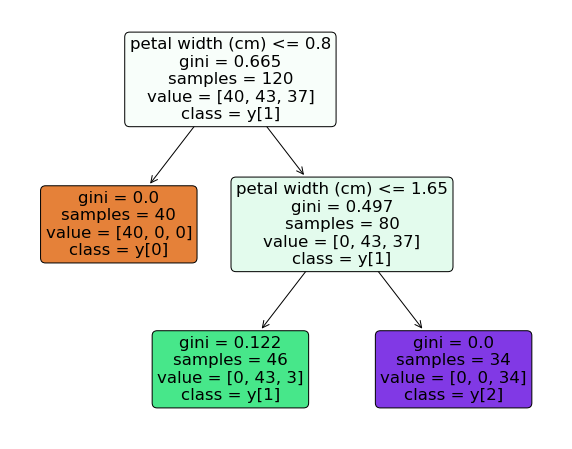

In [182]:
tree.plot_tree(clf_tree,
               feature_names=X.columns, class_names=True,
               filled=True, rounded=True,) 
plt.show()

In [183]:
# class y values
clf_tree.classes_

array([0, 1, 2])

In [184]:
from six import StringIO
import pydotplus
from sklearn import tree
from IPython.display import Image

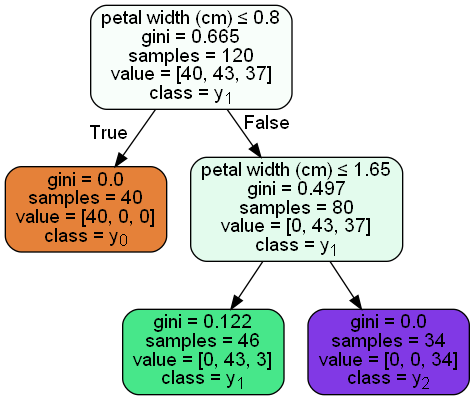

In [185]:
# tree visualization using graphviz
dot_file =StringIO()
tree.export_graphviz(clf_tree, 
                     feature_names = X.columns, 
                     out_file = dot_file, 
                     class_names=True,
                     filled =True, rounded=True, special_characters=True)
graph=pydotplus.graph_from_dot_data(dot_file.getvalue())
#graph.write_png("clf_tree.png") # save figure
Image(graph.create_png())

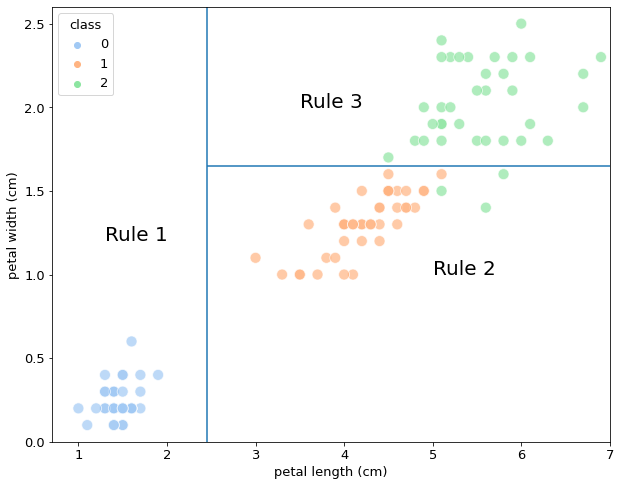

In [186]:
# plot classification results
sns.scatterplot(x='petal length (cm)', y='petal width (cm)', data=X_train,
                hue=y_train, s=120, alpha=0.7, palette='pastel')
plt.xlim(0.7,7)
plt.ylim(0,2.6)
plt.vlines(x=2.45, ymin=0, ymax=2.6)
plt.hlines(y=1.65, xmin=2.45, xmax=7)
plt.annotate('Rule 1', xy=(1.3,1.2), fontsize=20)
plt.annotate('Rule 2', xy=(5,1), fontsize=20)
plt.annotate('Rule 3', xy=(3.5,2), fontsize=20)
plt.show()

### 4. Impurity measures

+ gini index
    - $G(S) = 1-\sum^m_{k=1}p_k^2$
    - m : # of class
+ entropy
    - $E(S) = - \sum^m_{k=1}p_k\log_2(p_k)$
+ gain ratio
    - normalizing factor N(S) = $-(\frac{|S_{left}\,|}{|S|}\log_2\frac{|S_{left}\,|}{|S|}+\frac{|S_{right}\,|}{|S|}\log_2\frac{|S_{right}\,|}{|S|})$
    - gini gain ratio = $\frac{G-gain}{N(S)}$, entropy gain ratio = $\frac{E-gain}{N(S)}$
    - distinct한 값이 많은 수치형 변수를 주로 분기기준으로 선택하는 biased selcetion을 방지하기 위함
    - information gain ratio biases the decision tree against considering attributes with a large number of distinct values

In [187]:
clf_tree.tree_.impurity

array([0.66541667, 0.        , 0.4971875 , 0.12192817, 0.        ])

In [188]:
# gini index of root node
p_0 = (y_train == 0).sum() / len(y_train)
p_1 = (y_train == 1).sum() / len(y_train)
p_2 = (y_train == 2).sum() / len(y_train)

gini = 1 - (p_0**2 + p_1**2 + p_2**2)
gini.round(3)

0.665

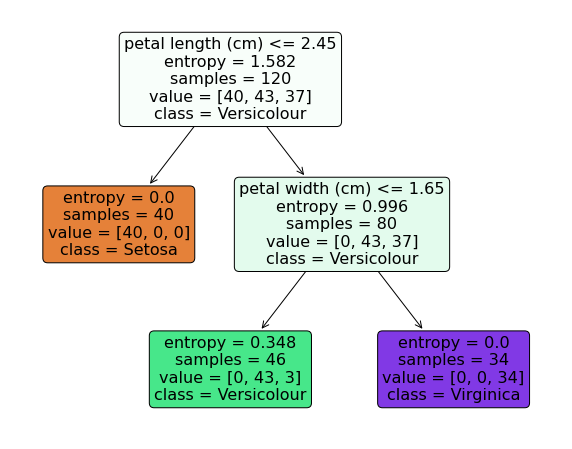

In [189]:
# fitting a tree using entropy gain
clf_tree = DecisionTreeClassifier(criterion = 'entropy', max_depth=2, random_state=111) 
clf_tree.fit(X_train, y_train)
tree.plot_tree(clf_tree,
               feature_names=X.columns, class_names=['Setosa', 'Versicolour', 'Virginica'],
               filled=True, rounded=True) 
plt.show()

In [190]:
# entropy of right child node
subset_y = y_train[X_train['petal length (cm)'] > 2.45]
p_0 = (subset_y == 0).sum() / len(subset_y) + 0.000001 # log(zero) is not defined
p_1 = (subset_y == 1).sum() / len(subset_y) + 0.000001
p_2 = (subset_y == 2).sum() / len(subset_y) + 0.000001

entropy = - p_0*np.log2(p_0) - p_1*np.log2(p_1) - p_2*np.log2(p_2)
entropy.round(3)

0.996

### 5. Preprocessing
+ categorical variables
    - sklearn에서는 모델 fitting 시 설명변수($X$)에서 숫자가 아닌 데이터는 다루지 못함. 목표변수($y$)는 상관없음.
    - label encoding
    - one-hot encoding
+ numerical variables
    - minMaxScaling, standardScaling
    - discretization
    - decision tree는 outlier에 덜 민감하기 때문에 수치형 변수를 scaling할 필요는 없으나, 수치형 변수의  
    biased selection을 방지하기 위해 구간 분할(binning)을 하기도 함. = bucketization, discretization

#### 5.1 Car dataset
+ car evaluation dataset
+ columns
    - buying : buying price(vhigh, high, med, low), 구매가격
    - maint : price of the maintenance(vhigh, high, med, low), 유지비
    - doors : number of doors
    - persons : capacity in terms of persons to carry, 탑승인원
    - lug_boot : the size of luggage boot(small, med, big), 짐칸 크기
    - safety : estimated safety of the car(low, med, high), 안전등급
    - class(target) : car evaluation(unacc, acc, good, vgood) 차량평가

In [191]:
# load dataset
df_car = pd.read_csv('car.csv',
                       names=['buying','maint','doors','persons','lug_boot','safety','class'])
df_car.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [192]:
# information about dataframe 
df_car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [193]:
# ValueError : could not convert string to float
X = df_car.drop(columns='class')
y = df_car['class']

clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=123)
clf_tree.fit(X, y)

ValueError: could not convert string to float: 'vhigh'

#### 5.2 Label encoding

+ Encode target labels with value between 0 and n_classes-1.
    - `buying` : vhigh -> 0, high -> 1, med -> 2, low ->3 
    - 주로 범주형 변수중 order가 있는 변수를 인코딩할 때 쓰임

In [194]:
# distinct values of `buying`
X['buying'].unique()

array(['vhigh', 'high', 'med', 'low'], dtype=object)

In [195]:
X['buying'], uniques = pd.factorize(df_car['buying'])
X['buying'].unique()

array([0, 1, 2, 3], dtype=int64)

In [196]:
# prior distinct values
uniques

Index(['vhigh', 'high', 'med', 'low'], dtype='object')

In [197]:
# factorizing every categorical values of predictors
cat_col = X.select_dtypes(include=['object']).columns.tolist()
X[cat_col] = X[cat_col].apply(lambda x: pd.factorize(x)[0])
X.head()
#X.info()

,buying,maint,doors,persons,lug_boot,safety
0,0,0,0,0,0,0
1,0,0,0,0,0,1
2,0,0,0,0,0,2
3,0,0,0,0,1,0
4,0,0,0,0,1,1


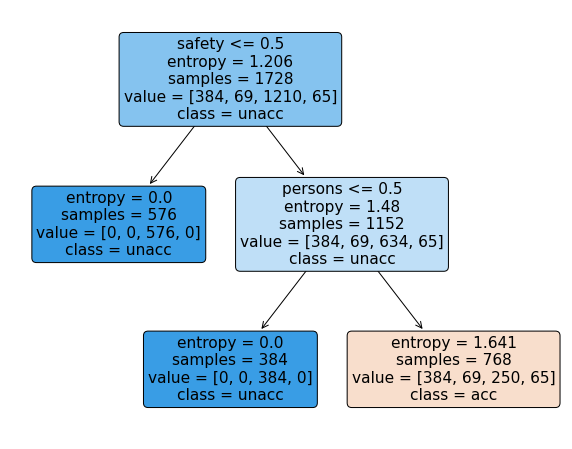

In [198]:
# fitting
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=123)
clf_tree.fit(X, y)

# plot tree
tree.plot_tree(clf_tree,
               feature_names=X.columns, class_names=clf_tree.classes_,
               filled=True, rounded=True,) 
plt.show()

In [199]:
# issue : target class order 
print(y.unique())
print(clf_tree.classes_)

['unacc' 'acc' 'vgood' 'good']
['acc' 'good' 'unacc' 'vgood']


#### 5.3 One-hot encoding

+ 범주형 값에 대한 더미 변수를 만듬
    - `buying`의 'vhigh', 'high', 'med', 'low' -> `buying_vhigh`, `buying_high`, `buying_med`, `buying_low` column들을 생성
    - feature 수가 많아진다는 단점이 있음

In [200]:
# X,y
X = df_car.drop(columns='class')
y = df_car['class']
X.head()

,buying,maint,doors,persons,lug_boot,safety
0,vhigh,vhigh,2,2,small,low
1,vhigh,vhigh,2,2,small,med
2,vhigh,vhigh,2,2,small,high
3,vhigh,vhigh,2,2,med,low
4,vhigh,vhigh,2,2,med,med


In [201]:
# create dummy variables from `buying`
pd.get_dummies(X, columns=['buying']).head()

,maint,doors,persons,lug_boot,safety,buying_high,buying_low,buying_med,buying_vhigh
0,vhigh,2,2,small,low,0,0,0,1
1,vhigh,2,2,small,med,0,0,0,1
2,vhigh,2,2,small,high,0,0,0,1
3,vhigh,2,2,med,low,0,0,0,1
4,vhigh,2,2,med,med,0,0,0,1


In [202]:
# one-hot encoding to predictors
cat_col = X.select_dtypes(include=['object']).columns.tolist()
X = pd.get_dummies(X, columns=cat_col)
X.head()
#X.info()

,buying_high,buying_low,buying_med,buying_vhigh,maint_high,maint_low,maint_med,maint_vhigh,doors_2,doors_3,...,doors_5more,persons_2,persons_4,persons_more,lug_boot_big,lug_boot_med,lug_boot_small,safety_high,safety_low,safety_med
0,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,1,0
1,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,0,1
2,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,1,0,0
3,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,1,0
4,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,0,1


#### 5.4 Scikit-learn preprocessing

+ sklearn.preprocessing.
    - LabelEncoder()
    - OneHotEncoder()
    - OrdinalEncoder()
    - MinMaxScaler()
    - KBinsDiscretizer()
    - ...

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing

In [203]:
from sklearn import preprocessing
X = df_car.drop(columns='class')
y = df_car['class']

In [204]:
# label encoding
le = preprocessing.LabelEncoder()
X['buying'] = le.fit_transform(X['buying'])
X.head()

,buying,maint,doors,persons,lug_boot,safety
0,3,vhigh,2,2,small,low
1,3,vhigh,2,2,small,med
2,3,vhigh,2,2,small,high
3,3,vhigh,2,2,med,low
4,3,vhigh,2,2,med,med


In [205]:
# one-hot encoding
oh = preprocessing.OneHotEncoder()
encoded = oh.fit_transform(X[['maint']])
pd.DataFrame(data=encoded.toarray(), columns=oh.get_feature_names_out())

,maint_high,maint_low,maint_med,maint_vhigh
0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0
...,...,...,...,...
1723,0.0,1.0,0.0,0.0
1724,0.0,1.0,0.0,0.0
1725,0.0,1.0,0.0,0.0
1726,0.0,1.0,0.0,0.0
